In [ ]:
from google.colab import drive

# Montar con Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define la ruta del archivo subido
zip_path = '/content/drive/MyDrive/_Trabajos/Proyecto/dataset_nuestro.zip'

# Extrae el contenido
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')  # Extraerás los archivos a la carpeta "dataset"

# Verifica la estructura descomprimida
os.listdir('/content/dataset')

['dataset_nuestro']

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os

# Definir los directorios
train_dir = "/content/dataset/dataset_nuestro/train"
augmented_train_dir = "/content/dataset/dataset_nuestro/augmented_train"  # No lo necesitamos guardar en disco realmente

img_height = 28
img_width = 28
augment_factor = 10  # Número de aumentos por imagen

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

all_images = []
all_labels = []

# Recorrer cada clase
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    label = int(class_name)

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.utils.load_img(img_path, color_mode='grayscale', target_size=(img_height, img_width))
        x = tf.keras.utils.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Añadir la imagen original
        all_images.append(x[0])
        all_labels.append(label)

        # Aumentar imágenes
        count = 0
        for batch in datagen.flow(x, batch_size=1):
            all_images.append(batch[0])
            all_labels.append(label)
            count += 1
            if count >= augment_factor:
                break

# Convertir a numpy arrays
x_train_augmented = np.array(all_images)
y_train_augmented = np.array(all_labels)

print(f"x_train_augmented shape: {x_train_augmented.shape}")
print(f"y_train_augmented shape: {y_train_augmented.shape}")

# Comprobar igualdad
assert x_train_augmented.shape[0] == y_train_augmented.shape[0], "Mismatch in number of samples!"

# Preprocesar
x_train_augmented = x_train_augmented / 255.0
x_train_augmented = 1 - x_train_augmented
x_train_augmented = np.clip(x_train_augmented, 0.0, 1.0)

# Convertir etiquetas a one-hot
y_train_augmented = to_categorical(y_train_augmented, num_classes=10)


x_train_augmented shape: (14102, 28, 28, 1)
y_train_augmented shape: (14102,)


Shape of x_train_augmented[1]: (28, 28, 1)
Type of x_train_augmented[1]: float32


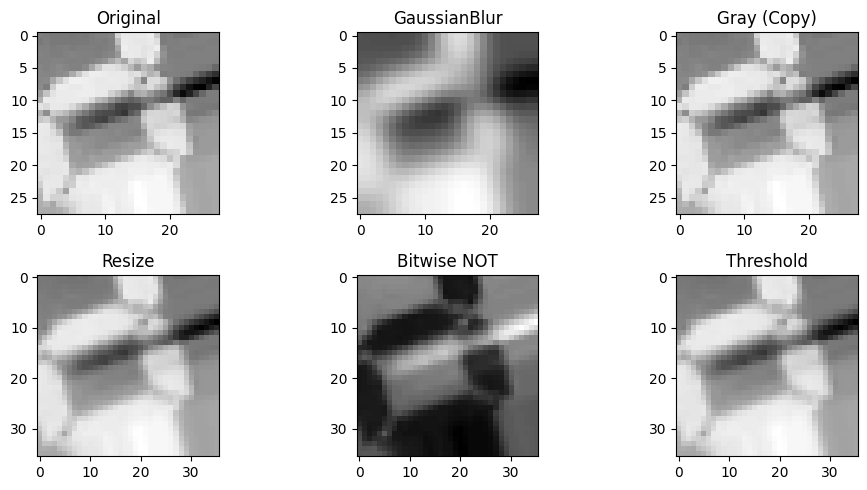

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que x_train_augmented está definido previamente
# (del código de aumento de datos anterior)

# Verificar si x_train_augmented está vacío
if x_train_augmented.size == 0:
    print("Error: x_train_augmented está vacío. Asegúrate de que el código de aumento se haya ejecutado correctamente.")
else:
    # Imprimir la forma y el tipo de datos para depurar
    print("Shape of x_train_augmented[1]:", x_train_augmented[1].shape)
    print("Type of x_train_augmented[1]:", x_train_augmented[1].dtype)

    img = (x_train_augmented[1] * 255).astype(np.uint8)

    img_ga = cv2.GaussianBlur(img, (9, 9), 0)
    img_g = img.copy()
    img_r = cv2.resize(img_g, (36, 36))
    img_i = cv2.bitwise_not(img_r)
    _, img_f = cv2.threshold(img_r, 0, 255, cv2.THRESH_TOZERO)

    plt.figure(figsize=(10, 5))
    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.subplot(2, 3, 2)
    plt.imshow(img_ga, cmap='gray')
    plt.title("GaussianBlur")
    plt.subplot(2, 3, 3)
    plt.imshow(img_g, cmap='gray')
    plt.title("Gray (Copy)")
    plt.subplot(2, 3, 4)
    plt.imshow(img_r, cmap='gray')
    plt.title("Resize")
    plt.subplot(2, 3, 5)
    plt.imshow(img_i, cmap='gray')
    plt.title("Bitwise NOT")
    plt.subplot(2, 3, 6)
    plt.imshow(img_f, cmap='gray')
    plt.title("Threshold")
    plt.tight_layout()
    plt.show()

97 242


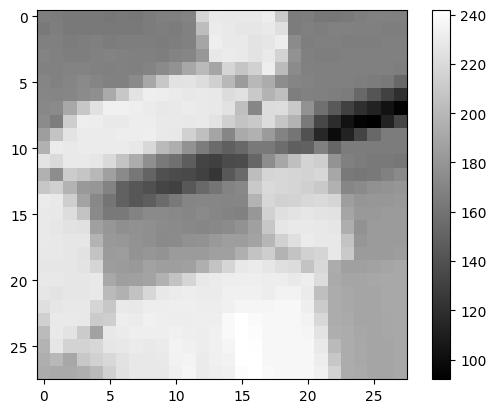

In [ ]:
print(np.min(img_f), np.max(img_f))  # Ver los valores mínimos y máximos
plt.imshow(img, cmap='gray')  # Mostrar la imagen antes del umbral
plt.colorbar()  # Agregar barra de colores para ver valores
plt.show()

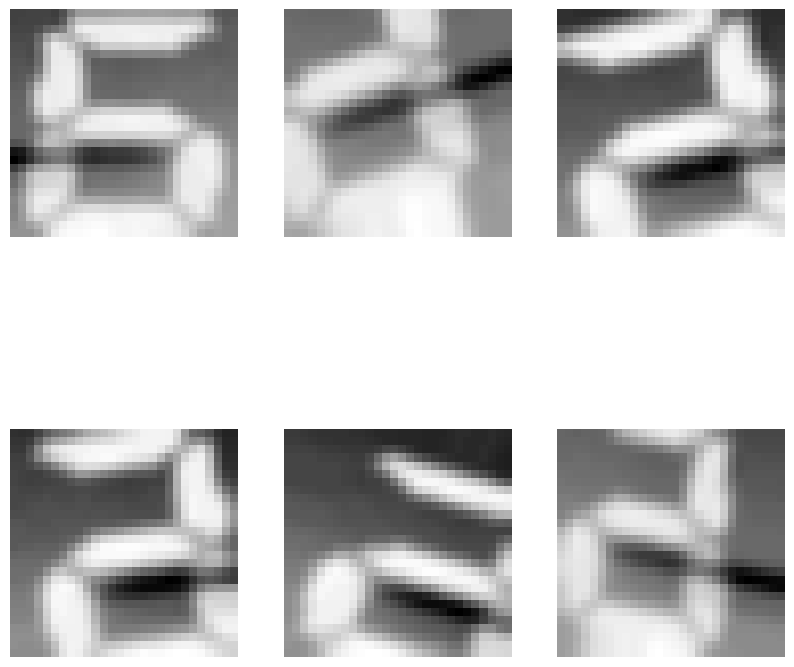

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Asegurar que x_train_augmented está en el rango correcto (0-255)
x_train_numpy = x_train_augmented.astype(np.float32)  # Convertir a float32 para la multiplicación
x_train_uint8 = (x_train_numpy * 255).astype(np.uint8)

# Lista para almacenar imágenes procesadas
x_train_processed = []

# Iterar sobre cada imagen en x_train_augmented
for img in x_train_uint8:
    img_ga = cv2.GaussianBlur(img, (3,3), 0)  # Filtro Gaussiano
    img_g = img_ga.copy()
    img_r = cv2.resize(img_g, (28,28), interpolation=cv2.INTER_NEAREST)  # Redimensionar
    img_i = cv2.bitwise_not(img_r)  # Invertir colores
    _, img_f = cv2.threshold(img_r, 40, 255, cv2.THRESH_TOZERO)  # Umbralizar

    # Convertir a int antes de guardar
    img_f_int = img_f.astype(int)
    x_train_processed.append(img_f_int)

# Convertir lista a array de numpy
x_train_processed = np.array(x_train_processed)

# Mostrar algunas imágenes de ejemplo
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_train_processed[i], cmap='gray')  # No necesitamos label aquí
    plt.axis('off')
plt.show()

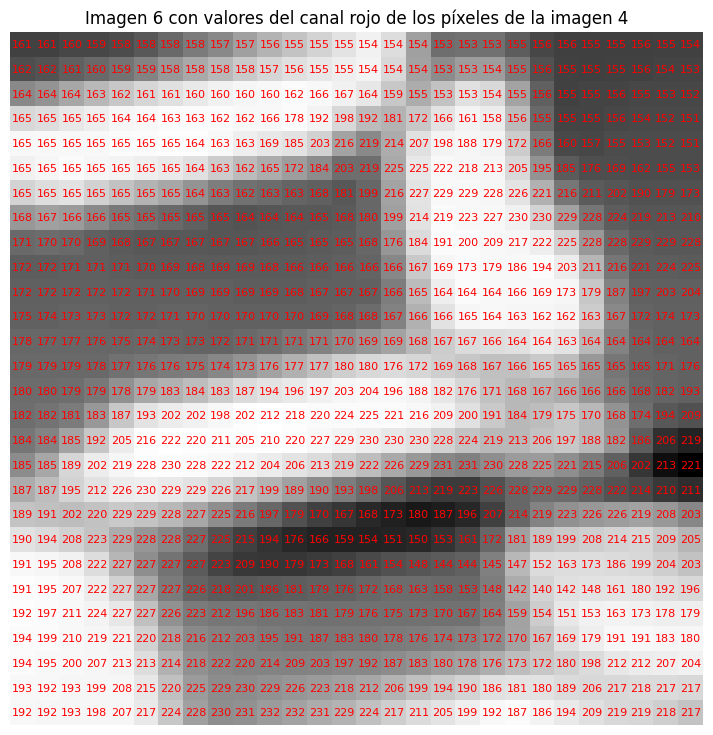

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if 'x_train_processed' in locals():
    if len(x_train_processed) > 6:
        plt.figure(figsize=(9, 9))
        plt.imshow(x_train_processed[6], cmap='gray')  # Podemos seguir mostrándola como escala de grises para la visualización principal
        for (j, i), pixel_value in np.ndenumerate(x_train_processed[4]):
            # Vamos a mostrar solo el valor del primer canal (por ejemplo, el rojo)
            # Puedes modificar esto para mostrar un promedio o los tres canales juntos si lo deseas
            plt.text(i, j, f"{pixel_value:.0f}", ha='center', va='center', color='red', fontsize=8)
        plt.title(f"Imagen {6} con valores del canal rojo de los píxeles de la imagen {4}")
        plt.axis('off')
        plt.show()
    else:
        print("No hay suficientes imágenes en x_train_processed para mostrar el índice 6.")
else:
    print("La variable x_train_processed no está definida. Asegúrate de ejecutar el código de procesamiento de imágenes primero.")

In [ ]:
import os
from tensorflow.keras.utils import to_categorical

test_path = "/content/dataset/dataset_nuestro/test"
x_test_processed = []
y_test = []

for label_str in sorted(os.listdir(test_path)):
    label_dir = os.path.join(test_path, label_str)
    if not os.path.isdir(label_dir):
        continue
    label = int(label_str)  # Convert folder name to label
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        img = cv.imread(img_path)
        img = cv.resize(img, (28, 28))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.bitwise_not(img)
        _, img = cv.threshold(img, 40, 255, cv.THRESH_TOZERO)
        img = img.astype("float32") / 255.0
        x_test_processed.append(img)
        y_test.append(label)

x_test_processed = np.array(x_test_processed).reshape(-1, 28, 28, 1)
y_test = np.array(y_test)
y_test = to_categorical(y_test, num_classes=10)

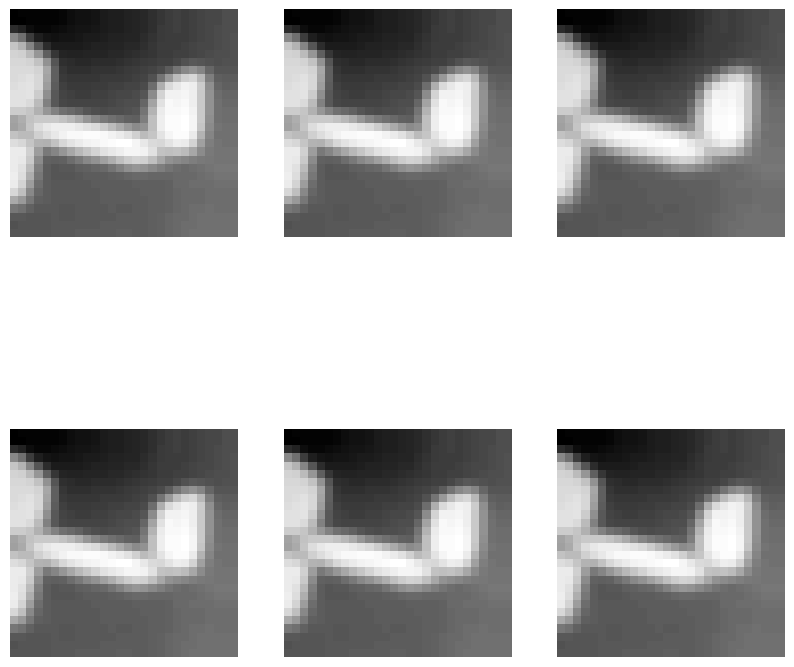

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Asegúrate de que x_test_processed es un array NumPy antes de empezar a procesar
# Asumo que ya tienes x_test_processed cargado en algún punto anterior del código
# Si no, debes cargarlo desde donde sea que lo estés obteniendo.
# Por ejemplo:
# x_test_processed = np.array(tu_lista_de_imagenes)

# Si x_test_processed es una lista, conviértela a un array NumPy
if isinstance(x_test_processed, list):
    x_test_processed = np.array(x_test_processed)


# Lista para almacenar imágenes procesadas
processed_images = []

# Iterar sobre cada imagen en x_test_processed
for img in x_test_processed:
    img_ga = cv2.GaussianBlur(img, (3, 3), 0)  # Filtro Gaussiano
    # img_g = cv2.cvtColor(img_ga, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
    img_r = cv2.resize(img_g, (28, 28), interpolation=cv2.INTER_NEAREST)  # Redimensionar
    img_i = cv2.bitwise_not(img_r)  # Invertir colores
    _, img_f = cv2.threshold(img_r, 40, 255, cv2.THRESH_TOZERO)  # Umbralizar

    processed_images.append(img_f)

# Convertir lista a array de numpy
x_test_processed = np.array(processed_images)


# Mostrar algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for i in range(min(6, len(x_test_processed))):  # Evita errores si hay menos de 6 imágenes
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_test_processed[i], cmap='gray')
    plt.axis('off')
plt.show()

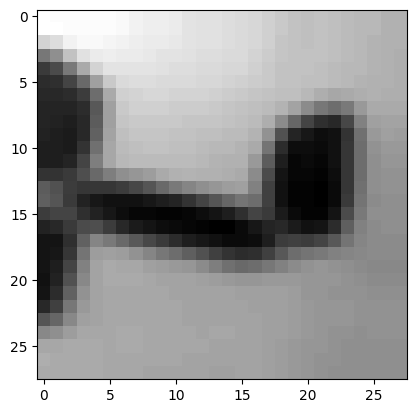

In [ ]:
import matplotlib.pyplot as plt
x_test_processed = x_test_processed / 255.0
x_test_processed = 255-x_test_processed
plt.imshow(x_test_processed[9], cmap="gray")
plt.show()

In [ ]:
x_train = x_train_augmented / 255.0
x_test_processed = x_test_processed / 255.0

In [ ]:
from tensorflow.keras.utils import to_categorical

nclases = 10
y_train = to_categorical(y_train_augmented,nclases)
y_test = to_categorical(y_test,nclases)

In [ ]:
print(x_train_processed.shape)
print(y_train.shape)
print(x_test_processed.shape)
print(y_test.shape)
x_test_processed = x_test_processed.reshape(-1, 28, 28, 1)
x_train_processed = x_train_processed.reshape(-1, 28, 28, 1)

(14102, 28, 28)
(14102, 10, 10)
(99, 28, 28)
(99, 10, 10)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 99 files belonging to 10 classes.
🔄 Entrenando un nuevo modelo...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2711 - loss: 2.0159 - val_accuracy: 0.5354 - val_loss: 1.1134
Epoch 2/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6002 - loss: 1.0354 - val_accuracy: 0.8283 - val_loss: 0.5225
Epoch 3/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7032 - loss: 0.7821 - val_accuracy: 0.9394 - val_loss: 0.2177
Epoch 4/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7912 - loss: 0.5777 - val_accuracy: 0.9091 - val_loss: 0.1669
Epoch 5/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8355 - loss: 0.4490 - val_accuracy: 0.9596 - val_loss: 0.1151
Epoch 6/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8637 - loss: 0.3813 - val_accuracy: 0.9798 - val_loss: 0.0732
Epoch 7/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8915 - loss: 0.3140 - val_accuracy: 0.9899 - val_loss: 0.0442
Epoch 8/20
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8962 - loss: 0.2900 

✅ Modelo guardado en formato .keras
✅ Modelo guardado en formato .h5
Saved artifact at '/tmp/tmpgama12in'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138986122707216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122718544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122708560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122716240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122719120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122707792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122718352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122716816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122719312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138986122721040:

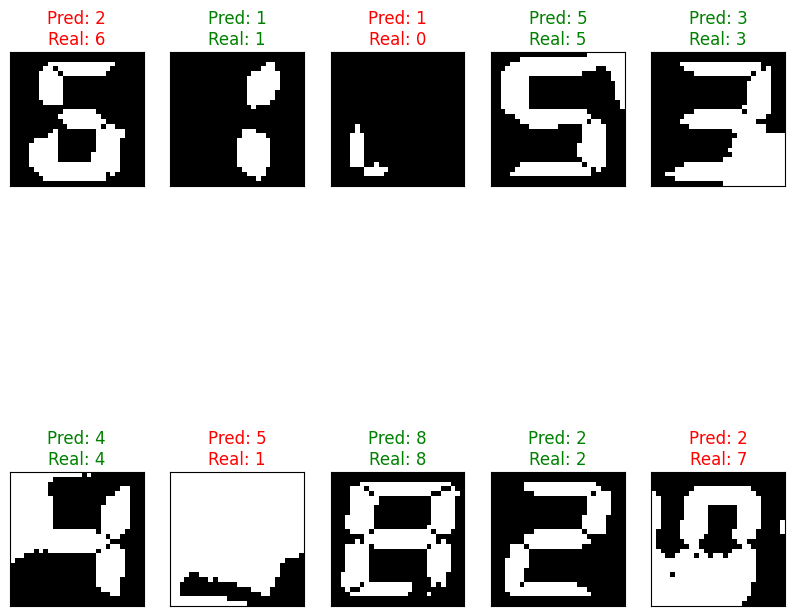

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import cv2 as cv

drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/Colab Notebooks"
folder_path, model_path = f"{drive_path}/imagenes/digitos", f"{drive_path}/modelos/modelo_digitos.keras"


def create_model():
    return Sequential([
        Conv2D(6, (5, 5), activation="relu", input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation="relu"),
        Dense(84, activation="relu"),
        Dropout(0.2),
        Dense(10, activation="softmax")
    ])


def compile_model(model):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def train_model(model, x_train, y_train, x_val, y_val, epochs=20, batch_size=8, verbose=1):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                        validation_data=(x_val, y_val))
    return history


def save_model(model, model_path="modelo_digitos.keras"):
    model.save(model_path, save_format="keras", include_optimizer=False)
    for layer in model.layers:
        if hasattr(layer, "dtype") and layer.dtype != "float32":
            layer._dtype_policy = tf.keras.mixed_precision.Policy("float32")

    model.save("modelo_digitos.keras", include_optimizer=False)
    print("✅ Modelo guardado en formato .keras")

    h5_path = model_path.replace(".keras", ".h5")
    model.save(h5_path)
    print("✅ Modelo guardado en formato .h5")

    tflite_path = model_path.replace(".keras", ".tflite")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print("✅ Modelo guardado en formato .tflite")


def load_or_train_model(x_train_augmented, y_train_augmented, x_test_processed, y_test_categorical):
    if os.path.exists(model_path):
        print("✅ Cargando modelo preentrenado...")
        model = tf.keras.models.load_model(model_path)
        return model

    print("🔄 Entrenando un nuevo modelo...")

    model = create_model()
    model = compile_model(model)

    train_model(model, x_train_augmented.reshape(-1, 28, 28, 1), y_train_augmented,
                x_test_processed, y_test_categorical)  # x_test_processed ya está en escala de grises

    save_model(model)
    return model


def predict_images(model):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.webp'))]

    plt.figure(figsize=(10, 10))
    for i, file_name in enumerate(image_files):
        true_label = int(file_name.split("_")[1].split(".")[0])
        img = np.array(Image.open(os.path.join(folder_path, file_name)).convert("L"))

        img = (img * 255).astype(np.uint8)
        img = cv.resize(img, (28, 28))
        img = cv.bitwise_not(img)
        _, img = cv.threshold(img, 78, 120, cv.THRESH_BINARY_INV)

        prediction = np.argmax(model.predict(img.reshape(1, 28, 28, 1)))

        color = "green" if prediction == true_label else "red"

        num_images = len(image_files)
        num_cols = 5
        num_rows = (num_images + num_cols - 1) // num_cols

        plt.subplot(num_rows, num_cols, i + 1)
        plt.xticks([]), plt.yticks([])
        plt.imshow(img, cmap='gray')
        plt.title(f"Pred: {prediction}\nReal: {true_label}", color=color)

        print(f"🖼️ {file_name} → Pred: {prediction} (Real: {true_label})")

    plt.show()


dataset_test = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/dataset_nuestro/test",
    image_size=(28, 28),
    batch_size=8,
    shuffle=False
)

x_test = []
y_test = []
for images, labels in dataset_test:
    x_test.append(tf.image.rgb_to_grayscale(images).numpy())  # Convertir a escala de grises
    y_test.append(labels.numpy())

x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

x_test_processed = x_test / 255.0
x_test_processed = 1 - x_test_processed
x_test_processed = np.clip(x_test_processed, 0.0, 1.0)

y_test_categorical = to_categorical(y_test, num_classes=10)

model = load_or_train_model(x_train_augmented, y_train_augmented, x_test_processed,
                            y_test_categorical)
predict_images(model)